### Informasi Eksperimen
FLUENT - ICONNIC


DNN (non-cross val; param default) vs RNN (non-cross val; param default) + (2); (3); (4)

(2) evaluasi dengan BLEU (3) analisa dengan 5 prompt pertanyaan yang dispesifikasikan dan 5 prompt bebas dari user (4) menujukkan hasil evaluasi hasil prompt bebas dengan kategori buruk netral baik

Referensi tambahan:
https://www.researchgate.net/publication/336203630_Indonesian_Chatbot_of_University_Admission_Using_a_Question_Answering_System_Based_on_Sequence-to-Sequence_Model

In [46]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import preprocessing, utils
import os
import yaml

# Retrieve data train

In [177]:
knowledgebase = pd.read_excel('https://raw.githubusercontent.com/AndiAlifs/FLUENT-Chatbot-2023/main/KnowledgeBaseFilkom.xlsx', engine='openpyxl')
knowledgebase.head()

,No,Contributor,Topik/Tag,Pertanyaan,Jenis,Jawaban,Link Jawaban,Keterangan Tambahan
0,0.0,Fitra,Informasi Dosen,email Fitra A. Bachtiar,Statis,fitra.bachtiar[at]ub.ac.id,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
1,NaN,NaN,NaN,NIK/NIP Fitra A. Bachtiar,Statis,198406282019031006,NaN,NaN
2,NaN,NaN,NaN,nama lengkap Fitra A. Bachtiar,Statis,Dr.Eng. Fitra A. Bachtiar,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
3,NaN,NaN,NaN,Departemen Fitra A. Bachtiar,Dinamis,Departemen Teknik Informatika,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
4,NaN,NaN,NaN,Program Studi Fitra A. Bachtiar,Dinamis,S2 Ilmu Komputer,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN


In [178]:
qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,email Fitra A. Bachtiar,fitra.bachtiar[at]ub.ac.id
1,NIK/NIP Fitra A. Bachtiar,198406282019031006
2,nama lengkap Fitra A. Bachtiar,Dr.Eng. Fitra A. Bachtiar
3,Departemen Fitra A. Bachtiar,Departemen Teknik Informatika
4,Program Studi Fitra A. Bachtiar,S2 Ilmu Komputer
...,...,...
1229,Apa Manfaat Konseling FILKOM ?,1. Masalah ditangani oleh ahli yang kompeten d...
1230,Berikan informasi mengenai Layanan Konseling,Informasi mengenai Layanan Konseling dapat dia...
1231,Siapa Konselor Bimbingan dan Konseling di FILK...,Ada 2 konselor Bimbingan dan Konseling di FILK...
1232,Siapa Koordinator Konselor Sebaya ?,Koordinator Konselor Sebaya adalah Muhammad Da...


# Implementasi RNN 

## Preprocessing Data

In [179]:
# remove all the punctuation from qa_paired
qa_paired['Pertanyaan'] = qa_paired['Pertanyaan'].str.replace('[^\w\s]',' ').str.lower()
qa_paired['Jawaban'] = qa_paired['Jawaban'].str.replace('[^\w\s]',' ').str.lower()

In [180]:
vocab = sorted(set(" ".join(qa_paired['Pertanyaan'] +" " + qa_paired['Jawaban']).split()))

In [181]:
questions = qa_paired['Pertanyaan']

answers = list()
for i in range( len(qa_paired['Jawaban']) ) :
    answers.append( '<START> ' + " ".join(qa_paired['Jawaban'].iloc[i].split()) + ' <END>' )

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 2600


### Encoder-Decoder

In [182]:
from gensim.models import Word2Vec
import re

In [53]:
vocab = []
for word in tokenizer.word_index:
  vocab.append(word)

def tokenize(sentences):
  tokens_list = []
  vocabulary = []
  for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    tokens = sentence.split()
    vocabulary += tokens
    tokens_list.append(tokens)
  return tokens_list, vocabulary

In [54]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data.shape, maxlen_questions)

(1198, 13) 13


In [55]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

(1198, 294) 294


In [56]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )

(1198, 294, 2600)


## Modelling

In [57]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# define the checkpoint
checkpoint = ModelCheckpoint('riset/fluent/2023/model_alif/rnn_model_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')

In [199]:
# reset model
tf.keras.backend.clear_session()

In [200]:
encoder_inputs = tf.keras.layers.Input(shape=( maxlen_questions , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 500 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 500 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( maxlen_answers ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 500 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 500 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 294)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 500)      1300000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 294, 500)     1300000     input_2[0][0]                    
______________________________________________________________________________________________

In [60]:
history = model.fit([encoder_input_data , decoder_input_data], 
                    decoder_output_data, 
                    batch_size=50, 
                    epochs=100,
                    callbacks=[checkpoint, 
                               earlystopping]) 

Epoch 1/100
24/24 [==============================] - 42s 1s/step - loss: 0.4441

Epoch 00001: loss improved from inf to 0.44414, saving model to riset/fluent/2023/model_alif/model_weights_Seq2Seq.h5
Epoch 2/100
24/24 [==============================] - 35s 1s/step - loss: 0.3895

Epoch 00002: loss improved from 0.44414 to 0.38950, saving model to riset/fluent/2023/model_alif/model_weights_Seq2Seq.h5
Epoch 3/100
24/24 [==============================] - 36s 1s/step - loss: 0.3575

Epoch 00003: loss improved from 0.38950 to 0.35755, saving model to riset/fluent/2023/model_alif/model_weights_Seq2Seq.h5
Epoch 4/100
24/24 [==============================] - 36s 1s/step - loss: 0.3320

Epoch 00004: loss improved from 0.35755 to 0.33197, saving model to riset/fluent/2023/model_alif/model_weights_Seq2Seq.h5
Epoch 5/100
24/24 [==============================] - 35s 1s/step - loss: 0.3098

Epoch 00005: loss improved from 0.33197 to 0.30979, saving model to riset/fluent/2023/model_alif/model_weights_

In [201]:
# load model best weights
model.load_weights('riset/fluent/2023/model_alif/model/rnn_model_weights.h5')

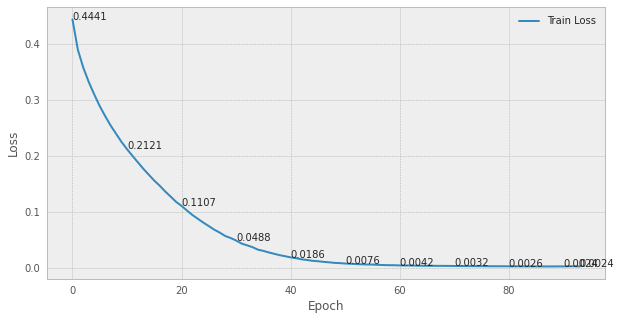

In [112]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
# plt.title('Model CatCross Entropy Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')

for i, loss in enumerate(history.history['loss']):
    # print("Epoch", i, ":", loss)
    if i % 10 == 0 or i == len(history.history['loss']) - 1:
        plt.annotate(str(round(loss, 4)), xy=(i,loss), xytext=(i,loss))
plt.show()


### Model Visualitation

## Test the chatbot

In [193]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 500 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 500 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]

    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [194]:
def str_to_tokens( sentence : str ):

    words = sentence.lower().split()
    tokens_list = list()

    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


In [207]:
def get_response_rnn(question):
    enc_model , dec_model = make_inference_models()

    quest = question

    states_values = enc_model.predict( str_to_tokens(quest) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    return decoded_translation.strip()

quest = input("Masukkan pertanyaan : ")
print("Pertanyaan : ", quest.strip())
print("Jawaban : ", get_response_rnn(quest))

Pertanyaan :  email fajar pradana
Jawaban :  fajar p at ub ac id end


# Implementasi DNN 

## Prepocessing Data

In [159]:
qa_paired_dnn = qa_paired
qa_paired_dnn['tag'] = qa_paired_dnn.index
qa_paired

,Pertanyaan,Jawaban,tag
0,email fitra a bachtiar,fitra bachtiar at ub ac id,0
1,nik nip fitra a bachtiar,198406282019031006,1
2,nama lengkap fitra a bachtiar,dr eng fitra a bachtiar,2
3,departemen fitra a bachtiar,departemen teknik informatika,3
4,program studi fitra a bachtiar,s2 ilmu komputer,4
...,...,...,...
1229,apa manfaat konseling filkom,1 masalah ditangani oleh ahli yang kompeten d...,1229
1230,berikan informasi mengenai layanan konseling,informasi mengenai layanan konseling dapat dia...,1230
1231,siapa konselor bimbingan dan konseling di filk...,ada 2 konselor bimbingan dan konseling di filk...,1231
1232,siapa koordinator konselor sebaya,koordinator konselor sebaya adalah muhammad da...,1232


In [136]:
X_train = qa_paired_dnn['Pertanyaan'].astype(str)

In [137]:
# tokenize Pertanyaan using tf 

tokenizer = Tokenizer(oov_token='x')
tokenizer.fit_on_texts(X_train)

doc_X = tokenizer.texts_to_sequences(X_train)
doc_X = pad_sequences(doc_X, maxlen=20, padding='post')

docs_Y = qa_paired_dnn['tag']
docs_Y = np.array(docs_Y).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
doc_Y = encoder.fit_transform(docs_Y)

output_shape = len(doc_Y[0])

[[24, 37, 31]]

## Modelling

In [125]:
#deep learning model
model_dnn = Sequential()
model_dnn.add(Dense(4096, input_shape=(20,), activation="relu"))
model_dnn.add(Dense(4096, activation="relu"))
model_dnn.add(Dense(2048, activation="relu"))
model_dnn.add(Dense(output_shape, activation="sigmoid"))
model_dnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])
print(model_dnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              86016     
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_5 (Dense)              (None, 1198)              2454702   
Total params: 27,712,686
Trainable params: 27,712,686
Non-trainable params: 0
_________________________________________________________________
None


In [126]:
# reset model
tf.keras.backend.clear_session()

In [129]:
checkpoint = ModelCheckpoint('riset/fluent/2023/model_alif/dnn_model_weights.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='max')

In [ ]:
history_model_dnn = model_dnn.fit(x=doc_X, 
                       y=doc_Y,
                       epochs=500,
                       verbose=1,
                       callbacks=[checkpoint, 
                               earlystopping])

In [131]:
model_dnn.load_weights('riset/fluent/2023/model_alif/model/dnn_model_weights.h5')

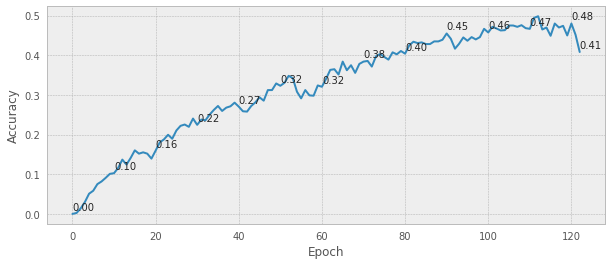

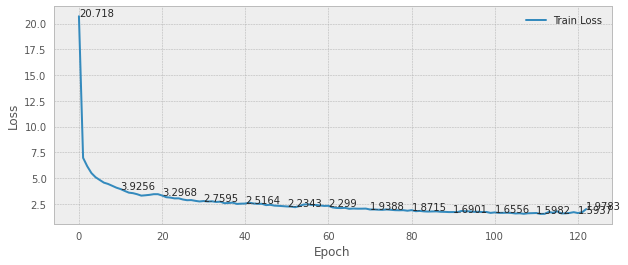

In [114]:
plt.plot(history_model_dnn.history['accuracy'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
# plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

for i, acc in enumerate(history_model_dnn.history['accuracy']):
    if i % 10 == 0 or i == len(history_model_dnn.history['accuracy']) - 1:
        plt.annotate('{:.2f}'.format(acc), xy=(i, acc), xytext=(i, acc + 0.01))

plt.show()

plt.plot(history_model_dnn.history['loss'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
# plt.title('Model CatCross Entropy Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')

for i, loss in enumerate(history_model_dnn.history['loss']):
    # print("Epoch", i, ":", loss)
    if i % 10 == 0 or i == len(history_model_dnn.history['loss']) - 1:
        plt.annotate(str(round(loss, 4)), xy=(i,loss), xytext=(i,loss))
plt.show()

## Test the chatbot

In [208]:
import numpy as np

def get_response_dnn(input_text):
    class_tag = predict_class(input_text)
    response = qa_paired_dnn[qa_paired_dnn['tag'] == class_tag].iloc[0].Jawaban.strip()
    return response

def predict_class(input_text):
    question = preprocess_input(input_text)
    pred = model_dnn.predict(question.reshape(1,20))
    return encoder.inverse_transform(np.array(pred))[0][0]

def preprocess_input(input_text):
    input_text = input_text.lower()
    input_text = re.sub('[^a-zA-Z]', ' ', input_text)
    tokenized_text = tokenizer.texts_to_sequences([input_text])[0]
    tokenized_text = pad_sequences([tokenized_text], maxlen=20, padding='post')[0]

    return tokenized_text

# Comparison Model

## Learning Curve by Loss

In [103]:
history_dnn = {
    'accuracy': history_model_dnn.history['accuracy'],
    'loss': history_model_dnn.history['loss']
}

history_rnn = {
    'loss': history.history['loss']
}

with open('riset/fluent/2023/model_alif/history_dnn_13923.yaml', 'w') as file:
    documents = yaml.dump(history_dnn, file)

with open('riset/fluent/2023/model_alif/history_rnn_13923.yaml', 'w') as file:
    documents = yaml.dump(history_rnn, file)

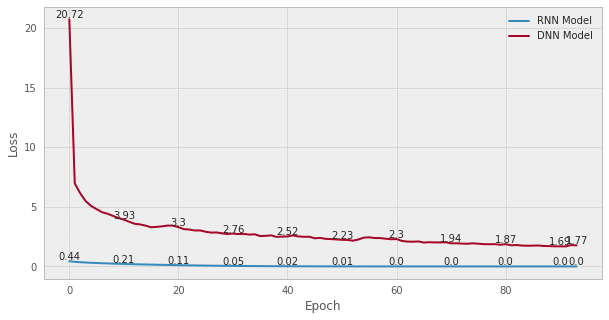

In [124]:
# remove whitegrid
plt.style.use('bmh')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

loss_rnn = history.history['loss'][:94]
loss_dnn = history_model_dnn.history['loss'][:94]

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.plot(loss_rnn, label='RNN Model')
plt.plot(loss_dnn, label='DNN Model')
plt.legend()

# Add value labels for every 20 epochs
for i, loss in enumerate(loss_rnn):
    if i % 10 == 0 or i == 93:
        plt.annotate(str(round(loss, 2)), xy=(i, loss), xytext=(i, loss+0.1), ha='center')

for i, loss in enumerate(loss_dnn):
    if i % 10 == 0 or i == 93:
        plt.annotate(str(round(loss, 2)), xy=(i, loss), xytext=(i, loss+0.1), ha='center')

plt.show()

## Answering Quesitons

In [191]:
tables = pd.read_csv('riset/fluent/2023/model_alif/rnn_preds_answers.csv')
tables.drop(columns=['pred_answers'], inplace=True)

prompts = [
    {
        "question": "email fajar pradana",
        "expected": tables[tables['questions'].str.contains("email fajar pradana").fillna(False)].iloc[0].real_answers.strip()
    },{
        "question": "kalender akademik",
        "expected": tables[tables['questions'].str.contains("kalender akademik").fillna(False)].iloc[0].real_answers.strip()
    },{
        "question": "informasi yudisium",
        "expected": tables[tables['questions'].str.contains("informasi yudisium").fillna(False)].iloc[0].real_answers.strip()
    },{
        "question": "apa itu laboratorium sistem cerdas",
        "expected": tables[tables['questions'].str.contains("laboratorium sistem cerdas").fillna(False)].iloc[2].real_answers.strip()
    }
]

In [ ]:
human_eval = pd.DataFrame(columns=['question', 'real_answers', 'rnn_answers', 'dnn_answers'])

for prompt in prompts:
    question = prompt['question']
    real_answer = prompt['expected']

    rnn_answer = get_response_rnn(question)
    dnn_answer = get_response_dnn(question)

    human_eval = human_eval.append({
        'question': question,
        'real_answers': real_answer,
        'rnn_answers': rnn_answer,
        'dnn_answers': dnn_answer
    }, ignore_index=True)

In [215]:
human_eval.to_csv('riset/fluent/2023/model_alif/human_eval.csv', index=False)
human_eval

,question,real_answers,rnn_answers,dnn_answers
0,email fajar pradana,fajar p at ub ac id,fajar p at ub ac id end,bayu_priyambadha at ub ac id
1,kalender akademik,https filkom ub ac id pendidikan kalender akad...,https filkom ub ac id pendidikan kalender akad...,merdeka filkom merupakan portal merdeka belaja...
2,informasi yudisium,https filkom ub ac id wp content uploads 2021 ...,https filkom ub ac id wp content uploads 2021 ...,halofilkom merupakan platform ticketing yang d...
3,apa itu laboratorium sistem cerdas,laboratorium sistem cerdas merupakan salah sat...,laboratorium sistem cerdas merupakan salah sat...,laboratorium sistem cerdas merupakan salah sat...


## BLEU Score

In [223]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    bleu_score_all = 0

    num_of_rows_calculated = 0

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        try:
            refs = [real_answer.split(' ')]
            hyp = preds[i].split(' ')

            bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0))
            bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0))
            bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0))
            bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1))
            bleu_score_all += sentence_bleu(refs, hyp, weights=(.25,.25,.25,.25))

            num_of_rows_calculated+=1
        except:
            continue

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_all/num_of_rows_calculated)}
    
    return results

### RNN Scoring

In [228]:
tables = pd.read_csv('riset/fluent/2023/model_alif/rnn_preds_answers.csv')

rnn_bleu = calculate_bleu(tables['pred_answers'], tables['questions'], tables['real_answers'])
rnn_bleu['mean'] = np.mean(list(rnn_bleu.values()))

/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunctio

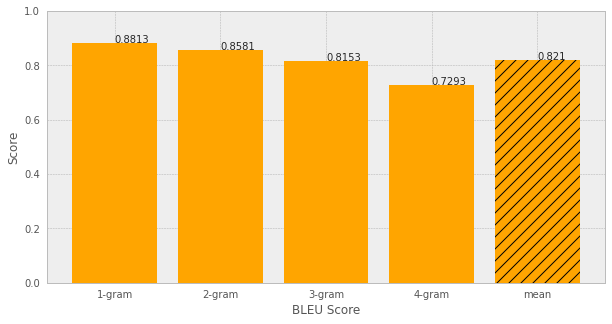

<Figure size 1440x720 with 0 Axes>

In [231]:
plt.style.use('bmh')
plt.xlabel('BLEU Score')
plt.ylabel('Score')
for index, (key, value) in enumerate(rnn_bleu.items()):
    if index == len(rnn_bleu.values()) - 1:
        plt.bar(index, value, color='orange', hatch='//')
    else:
        plt.bar(index, value, color='orange')
    plt.text(index, value, str(round(value, 4)))
plt.xticks(range(len(rnn_bleu)), rnn_bleu.keys())
plt.yticks(np.arange(0, 1.03, 0.2))
plt.figure(figsize=(20, 10))
plt.show()

### DNN Scoring

In [ ]:
dnn_preds_answers = []
for question in tables['questions']:
    try:
        dnn_preds_answers.append(get_response_dnn(question))
    except:
        dnn_preds_answers.append('tidak mengerti input')
        print(question)

In [ ]:
dnn_bleu = calculate_bleu(dnn_preds_answers, tables['questions'], tables['real_answers'])
dnn_bleu['mean'] = np.mean(list(dnn_bleu.values()))

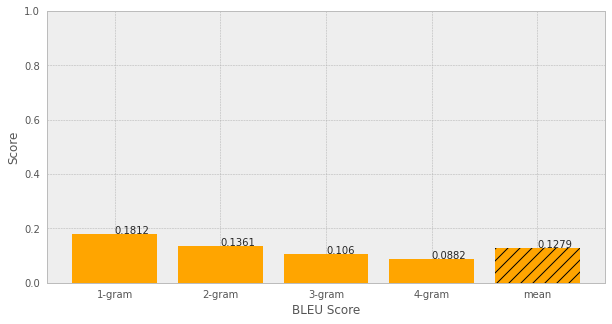

<Figure size 1440x720 with 0 Axes>

In [238]:
plt.style.use('bmh')
plt.xlabel('BLEU Score')
plt.ylabel('Score')
for index, (key, value) in enumerate(dnn_bleu.items()):
    if index == len(dnn_bleu.values()) - 1:
        plt.bar(index, value, color='orange', hatch='//')
    else:
        plt.bar(index, value, color='orange')
    plt.text(index, value, str(round(value, 4)))
plt.xticks(range(len(dnn_bleu)), dnn_bleu.keys())
plt.yticks(np.arange(0, 1.03, 0.2))
plt.figure(figsize=(20, 10))
plt.show()

### Comparison BLEU Score

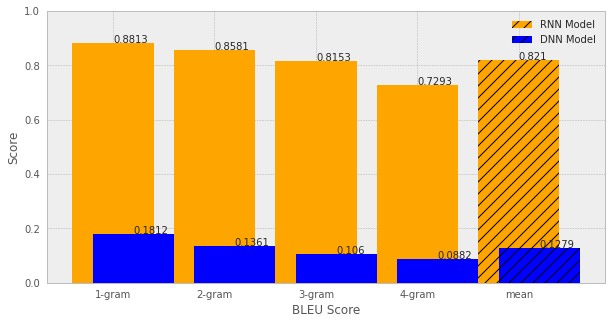

<Figure size 1440x720 with 0 Axes>

In [245]:
# combine and compare two bleu score in grouped bar chart
plt.style.use('bmh')
plt.xlabel('BLEU Score')
plt.ylabel('Score')
for index, (key, value) in enumerate(rnn_bleu.items()):
    if index == len(rnn_bleu.values()) - 1:
        plt.bar(index, value, color='orange', hatch='//', label='RNN Model')
    else:
        plt.bar(index, value, color='orange', label='_nolegend_')
    plt.text(index, value, str(round(value, 4)))
for index, (key, value) in enumerate(dnn_bleu.items()):
    if index == len(dnn_bleu.values()) - 1:
        plt.bar(index+0.2, value, color='blue', hatch='//', label='DNN Model')
    else:
        plt.bar(index+0.2, value, color='blue', label='_nolegend_')
    plt.text(index+0.2, value, str(round(value, 4)))
plt.xticks(range(len(rnn_bleu)), rnn_bleu.keys())
plt.yticks(np.arange(0, 1.03, 0.2))
plt.legend()
plt.figure(figsize=(20, 10))
plt.show()